In [1]:
import os
import datetime

def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    

os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

### 1. 准备数据

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

In [3]:
# 实例化数据对象
transforms_train = transforms.Compose(
    [transforms.ToTensor()])
transforms_valid = transforms.Compose(
    [transforms.ToTensor()])

In [4]:
img_train = datasets.ImageFolder('./data/cifar2/train/',
            transform=transforms_train, target_transform=lambda t: torch.tensor([t]).float())
img_valid = datasets.ImageFolder('./data/cifar2/test/',
            transform=transforms_valid, target_transform=lambda t: torch.tensor([t]).float())

# 类别转为索引
print(img_train.class_to_idx)

{'0_airplane': 0, '1_automobile': 1}


In [16]:
# 使用管道将数据集转为pytorch可迭代的对象
# 在notebook 中不能使用多进程，否则会出错，所以num_workers指定为0
dl_train = DataLoader(img_train, batch_size=50, shuffle=True, num_workers=0)
dl_valid = DataLoader(img_valid, batch_size=50, shuffle=True, num_workers=0)

In [6]:
from matplotlib import pyplot as plt

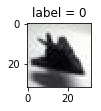

In [7]:
# 查看样本样例
%matplotlib inline
%config InlineBackend.figure = 'svg'

plt.figure(facecolor='w')
for i in range(9):
    img, label = img_train[i]
    img = img.permute(1, 2, 0)
    ax = plt.subplot(3, 3, i+1)
    ax.imshow(img.numpy())
    ax.set_title('label = %d' % label.item())
    plt.show()
    break

In [27]:
for x, y in dl_train:
    print(x.shape, y.shape)
    break

torch.Size([50, 3, 32, 32]) torch.Size([50, 1])


### 2. 定义模型
词出选择nn.Module基类构建自定义模型

In [8]:
pool = nn.AdaptiveMaxPool2d((1, 1))
t = torch.randn(10, 8, 32, 32)
pool(t).shape

torch.Size([10, 8, 1, 1])

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.dropout = nn.Dropout2d(p=0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)    # 卷积
        x = self.pool(x)     # 池化
        x = self.conv2(x)    
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        
        return y


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten()
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### 3. 训练模型
* 函数形式训练循环

In [21]:
import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score

In [11]:
model = net
model.optimizer = torch.optim.SGD(model.parameters(), lr=.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred, y_true: roc_auc_score(y_true.data.numpy(), y_pred.data.numpy())
model.metric_name = 'auc'

In [17]:
def train_step(model, features, labels):
    model.train()    # 训练模型
    model.optimizer.zero_grad()    # 梯度清零
    
    predictions = model(features)   # 正向传播求损失
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)
    
    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()
    return loss.item(), metric.item()


def valid_step(model, features, labels):
    # 预测模式，dropout不发生作用
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions, labels)
        metric = model.metric_func(predictions, labels)
        return loss.item(), metric.item()

# 测试训练效果
features, labels = next(iter(dl_train))
train_step(model, features, labels)

(0.6951138973236084, 0.5256410256410255)

In [22]:
def train_model(model, epochs, dl_train, dl_valid, log_step_freq):
    metric_name = model.metric_name
    history = pd.DataFrame(columns=[
       "epoch","loss",metric_name,"val_loss","val_"+metric_name 
    ])
    print('Start Training ...')
    
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print('============' * 8, nowtime)

    for epoch in tqdm.tqdm(range(1, epochs + 1)):
        # 训练循环
        loss_sum = .0
        metric_sum = .0
        
        step = 1
        for step, (features, labels) in enumerate(dl_train, 1):
            loss, metric = train_step(model, features, labels)
            loss_sum += loss
            metric_sum += metric
            if step % log_step_freq == 0:
                print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                      (step, loss_sum/step, metric_sum/step))
                
        # 验证循环
        val_loss_sum = .0
        val_metric_sum = .0
        val_step = 1
        for val_step, (features,labels) in enumerate(dl_valid, 1):
            val_loss,val_metric = valid_step(model,features,labels)

            val_loss_sum += val_loss
            val_metric_sum += val_metric
        # 3，记录日志-------------------------------------------------
        info = (epoch, loss_sum/step, metric_sum/step, 
                val_loss_sum/val_step, val_metric_sum/val_step)
        history.loc[epoch-1] = info

        # 打印epoch级别日志
        print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
              "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
              %info)
        nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print("\n"+"=========="*8 + "%s"%nowtime)

    print('Finished Training...')
    
    return history    
        

In [23]:
history = train_model(model, 20, dl_train, dl_valid, log_step_freq=50)

  0%|                                                                       | 0/20 [00:00<?, ?it/s]

Start Training ...
================================================================================================ 2020-10-20 19:51:54
[step = 50] loss: 0.691, auc: 0.639
[step = 100] loss: 0.690, auc: 0.682
[step = 150] loss: 0.689, auc: 0.696
[step = 200] loss: 0.687, auc: 0.711


  5%|███                                                         | 1/20 [03:52<1:13:45, 232.91s/it]


EPOCH = 1, loss = 0.687,auc  = 0.711, val_loss = 0.677, val_auc = 0.816

================================================================================2020-10-20 19:55:47
[step = 50] loss: 0.674, auc: 0.789
[step = 100] loss: 0.672, auc: 0.791
[step = 150] loss: 0.668, auc: 0.791
[step = 200] loss: 0.664, auc: 0.796


 10%|██████▏                                                       | 2/20 [04:08<50:18, 167.69s/it]


EPOCH = 2, loss = 0.664,auc  = 0.796, val_loss = 0.640, val_auc = 0.825

================================================================================2020-10-20 19:56:03
[step = 50] loss: 0.637, auc: 0.807
[step = 100] loss: 0.630, auc: 0.803
[step = 150] loss: 0.622, auc: 0.802
[step = 200] loss: 0.614, auc: 0.801


 15%|█████████▎                                                    | 3/20 [04:23<34:31, 121.83s/it]


EPOCH = 3, loss = 0.614,auc  = 0.801, val_loss = 0.567, val_auc = 0.831

================================================================================2020-10-20 19:56:18
[step = 50] loss: 0.572, auc: 0.800
[step = 100] loss: 0.565, auc: 0.802
[step = 150] loss: 0.559, auc: 0.805
[step = 200] loss: 0.555, auc: 0.804


 20%|████████████▌                                                  | 4/20 [04:37<23:54, 89.65s/it]


EPOCH = 4, loss = 0.555,auc  = 0.804, val_loss = 0.514, val_auc = 0.832

================================================================================2020-10-20 19:56:32
[step = 50] loss: 0.527, auc: 0.817
[step = 100] loss: 0.524, auc: 0.819
[step = 150] loss: 0.527, auc: 0.816
[step = 200] loss: 0.526, auc: 0.817


 25%|███████████████▊                                               | 5/20 [04:52<16:49, 67.28s/it]


EPOCH = 5, loss = 0.526,auc  = 0.817, val_loss = 0.492, val_auc = 0.844

================================================================================2020-10-20 19:56:47
[step = 50] loss: 0.520, auc: 0.825
[step = 100] loss: 0.514, auc: 0.829
[step = 150] loss: 0.513, auc: 0.831
[step = 200] loss: 0.514, auc: 0.830


 30%|██████████████████▉                                            | 6/20 [05:07<12:02, 51.57s/it]


EPOCH = 6, loss = 0.514,auc  = 0.830, val_loss = 0.478, val_auc = 0.852

================================================================================2020-10-20 19:57:02
[step = 50] loss: 0.505, auc: 0.838
[step = 100] loss: 0.511, auc: 0.833
[step = 150] loss: 0.511, auc: 0.830
[step = 200] loss: 0.502, auc: 0.837


 35%|██████████████████████                                         | 7/20 [05:23<08:49, 40.73s/it]


EPOCH = 7, loss = 0.502,auc  = 0.837, val_loss = 0.468, val_auc = 0.858

================================================================================2020-10-20 19:57:17
[step = 50] loss: 0.500, auc: 0.835
[step = 100] loss: 0.492, auc: 0.843
[step = 150] loss: 0.497, auc: 0.838
[step = 200] loss: 0.494, auc: 0.841


 40%|█████████████████████████▏                                     | 8/20 [05:39<06:39, 33.26s/it]


EPOCH = 8, loss = 0.494,auc  = 0.841, val_loss = 0.459, val_auc = 0.865

================================================================================2020-10-20 19:57:33
[step = 50] loss: 0.492, auc: 0.842
[step = 100] loss: 0.489, auc: 0.845
[step = 150] loss: 0.491, auc: 0.845
[step = 200] loss: 0.487, auc: 0.848


 45%|████████████████████████████▎                                  | 9/20 [05:53<05:05, 27.74s/it]


EPOCH = 9, loss = 0.487,auc  = 0.848, val_loss = 0.449, val_auc = 0.871

================================================================================2020-10-20 19:57:48
[step = 50] loss: 0.463, auc: 0.864
[step = 100] loss: 0.473, auc: 0.858
[step = 150] loss: 0.480, auc: 0.852
[step = 200] loss: 0.478, auc: 0.854


 50%|███████████████████████████████                               | 10/20 [06:08<03:58, 23.84s/it]


EPOCH = 10, loss = 0.478,auc  = 0.854, val_loss = 0.441, val_auc = 0.876

================================================================================2020-10-20 19:58:03
[step = 50] loss: 0.479, auc: 0.854
[step = 100] loss: 0.473, auc: 0.859
[step = 150] loss: 0.467, auc: 0.863
[step = 200] loss: 0.467, auc: 0.863


 55%|██████████████████████████████████                            | 11/20 [06:23<03:09, 21.04s/it]


EPOCH = 11, loss = 0.467,auc  = 0.863, val_loss = 0.430, val_auc = 0.886

================================================================================2020-10-20 19:58:17
[step = 50] loss: 0.463, auc: 0.866
[step = 100] loss: 0.462, auc: 0.868
[step = 150] loss: 0.459, auc: 0.869
[step = 200] loss: 0.458, auc: 0.871


 60%|█████████████████████████████████████▏                        | 12/20 [06:37<02:31, 18.99s/it]


EPOCH = 12, loss = 0.458,auc  = 0.871, val_loss = 0.433, val_auc = 0.895

================================================================================2020-10-20 19:58:32
[step = 50] loss: 0.455, auc: 0.872
[step = 100] loss: 0.448, auc: 0.878
[step = 150] loss: 0.451, auc: 0.878
[step = 200] loss: 0.449, auc: 0.880


 65%|████████████████████████████████████████▎                     | 13/20 [06:51<02:03, 17.61s/it]


EPOCH = 13, loss = 0.449,auc  = 0.880, val_loss = 0.414, val_auc = 0.901

================================================================================2020-10-20 19:58:46
[step = 50] loss: 0.439, auc: 0.880
[step = 100] loss: 0.434, auc: 0.883
[step = 150] loss: 0.433, auc: 0.885
[step = 200] loss: 0.431, auc: 0.888


 70%|███████████████████████████████████████████▍                  | 14/20 [07:05<01:39, 16.58s/it]


EPOCH = 14, loss = 0.431,auc  = 0.888, val_loss = 0.400, val_auc = 0.906

================================================================================2020-10-20 19:59:00
[step = 50] loss: 0.425, auc: 0.895
[step = 100] loss: 0.423, auc: 0.897
[step = 150] loss: 0.422, auc: 0.897
[step = 200] loss: 0.419, auc: 0.898


 75%|██████████████████████████████████████████████▌               | 15/20 [07:20<01:20, 16.04s/it]


EPOCH = 15, loss = 0.419,auc  = 0.898, val_loss = 0.378, val_auc = 0.914

================================================================================2020-10-20 19:59:15
[step = 50] loss: 0.421, auc: 0.903
[step = 100] loss: 0.423, auc: 0.902
[step = 150] loss: 0.421, auc: 0.903
[step = 200] loss: 0.420, auc: 0.906


 80%|█████████████████████████████████████████████████▌            | 16/20 [07:35<01:02, 15.63s/it]


EPOCH = 16, loss = 0.420,auc  = 0.906, val_loss = 0.373, val_auc = 0.923

================================================================================2020-10-20 19:59:30
[step = 50] loss: 0.413, auc: 0.907
[step = 100] loss: 0.407, auc: 0.909
[step = 150] loss: 0.405, auc: 0.909
[step = 200] loss: 0.403, auc: 0.912


 85%|████████████████████████████████████████████████████▋         | 17/20 [07:49<00:45, 15.06s/it]


EPOCH = 17, loss = 0.403,auc  = 0.912, val_loss = 0.355, val_auc = 0.929

================================================================================2020-10-20 19:59:43
[step = 50] loss: 0.394, auc: 0.918
[step = 100] loss: 0.400, auc: 0.919
[step = 150] loss: 0.399, auc: 0.918
[step = 200] loss: 0.393, auc: 0.919


 90%|███████████████████████████████████████████████████████▊      | 18/20 [08:03<00:29, 14.76s/it]


EPOCH = 18, loss = 0.393,auc  = 0.919, val_loss = 0.350, val_auc = 0.933

================================================================================2020-10-20 19:59:57
[step = 50] loss: 0.385, auc: 0.925
[step = 100] loss: 0.378, auc: 0.926
[step = 150] loss: 0.380, auc: 0.928
[step = 200] loss: 0.383, auc: 0.926


 95%|██████████████████████████████████████████████████████████▉   | 19/20 [08:16<00:14, 14.45s/it]


EPOCH = 19, loss = 0.383,auc  = 0.926, val_loss = 0.343, val_auc = 0.935

================================================================================2020-10-20 20:00:11
[step = 50] loss: 0.363, auc: 0.930
[step = 100] loss: 0.368, auc: 0.931
[step = 150] loss: 0.369, auc: 0.929
[step = 200] loss: 0.365, auc: 0.931


100%|██████████████████████████████████████████████████████████████| 20/20 [08:30<00:00, 25.52s/it]


EPOCH = 20, loss = 0.365,auc  = 0.931, val_loss = 0.364, val_auc = 0.940

================================================================================2020-10-20 20:00:25
Finished Training...


### 4. 模型评估
### 5. 模型保存
### 6. 部署使用